In [2]:
import numpy as np
import cv2 
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np

# Loading the Dataset

In [3]:
training_data = keras.preprocessing.image_dataset_from_directory("../input/face-mask-dataset/data", 
                                                           image_size=(224, 224), batch_size=64, validation_split = 0.2, subset="training", seed=1337)

validation_data = keras.preprocessing.image_dataset_from_directory("../input/face-mask-dataset/data", 
                                                           image_size=(224, 224), batch_size=64, validation_split = 0.2, subset="validation", seed=1337)


Found 7553 files belonging to 2 classes.
Using 6043 files for training.
Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [4]:
for image, label in training_data.take(1):
    print(image.shape)
    print(label.shape)

(64, 224, 224, 3)
(64,)


In [5]:
type(training_data)

tensorflow.python.data.ops.dataset_ops.BatchDataset

## Display the dataset

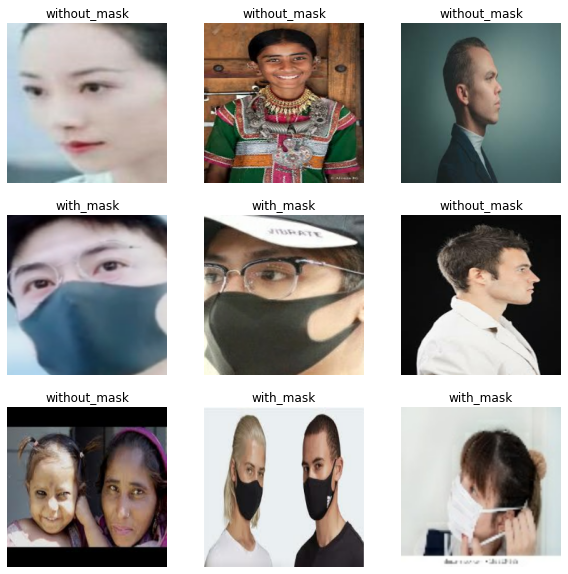

In [6]:
class_names = training_data.class_names
plt.figure(figsize=(10, 10))
for images, labels in training_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Load MobileNetv2

In [7]:
base_model = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

In [8]:
base_model.trainable = False

x = base_model.output
y = AveragePooling2D(pool_size=(7, 7))(x)
y = Flatten(name="flatten")(y)
y = Dense(128, activation="relu")(y)
y = Dropout(0.5)(y)
y = Dense(2, activation="softmax")(y)
model = Model(inputs = base_model.input, outputs = y)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

# Fine tuning

In [10]:
LR = 1e-4
EPOCHS = 20

In [11]:
opt = Adam(lr=LR, decay=LR / EPOCHS)

In [12]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

In [13]:
history = model.fit(training_data, validation_data = validation_data, epochs = EPOCHS)

Epoch 1/20
95/95 [==============================] - 64s 609ms/step - loss: 0.7598 - accuracy: 0.6148 - val_loss: 0.4374 - val_accuracy: 0.8113
Epoch 2/20
95/95 [==============================] - 23s 233ms/step - loss: 0.4393 - accuracy: 0.8047 - val_loss: 0.3603 - val_accuracy: 0.8523
Epoch 3/20
95/95 [==============================] - 23s 238ms/step - loss: 0.3656 - accuracy: 0.8437 - val_loss: 0.3272 - val_accuracy: 0.8642
Epoch 4/20
95/95 [==============================] - 23s 236ms/step - loss: 0.3288 - accuracy: 0.8613 - val_loss: 0.3004 - val_accuracy: 0.8781
Epoch 5/20
95/95 [==============================] - 23s 233ms/step - loss: 0.2973 - accuracy: 0.8857 - val_loss: 0.2854 - val_accuracy: 0.8854
Epoch 6/20
95/95 [==============================] - 23s 233ms/step - loss: 0.2777 - accuracy: 0.8851 - val_loss: 0.2716 - val_accuracy: 0.8921
Epoch 7/20
95/95 [==============================] - 23s 235ms/step - loss: 0.2797 - accuracy: 0.8856 - val_loss: 0.2645 - val_accuracy: 0.8934

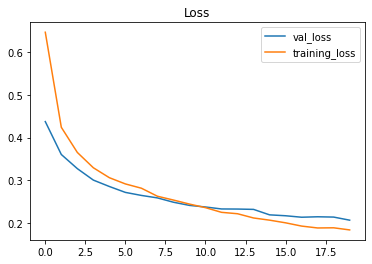

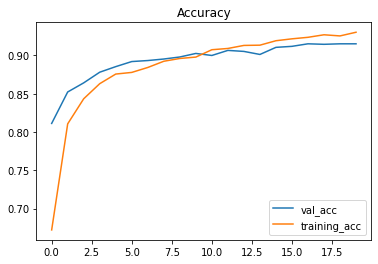

In [14]:
plt.figure()
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.legend(["val_loss", "training_loss"])
plt.title("Loss")
plt.figure()
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["accuracy"])
plt.legend(["val_acc", "training_acc"])
plt.title("Accuracy")
plt.show()

# Save the trained model

In [15]:
model.save('./model')